# Linear Dataset where t=1 is a linear function of t=0

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt

base_dir = Path(".").absolute().parents[0]
import sys

if sys.path[0] != base_dir.as_posix():
    sys.path = [base_dir.as_posix()] + sys.path

In [2]:
from spatio_temporal.config import Config
from spatio_temporal.training.trainer import Trainer
from spatio_temporal.training.tester import Tester
from tests.utils import (
    create_linear_ds,
    _test_sklearn_model,
    get_pollution_data_beijing,
)
from spatio_temporal.training.eval_utils import _plot_loss_curves, save_losses

# Load in Data

In [3]:
ds = create_linear_ds(epsilon_sigma=10)
ds

<xarray.Dataset>
Dimensions:  (lat: 10, lon: 10, time: 252)
Coordinates:
  * lat      (lat) float64 -55.15 -40.69 -26.22 -11.76 ... 46.1 60.56 75.02
  * lon      (lon) float64 -180.0 -140.0 -100.0 -60.0 ... 60.0 100.0 140.0 180.0
  * time     (time) datetime64[ns] 2000-01-31 2000-02-29 ... 2020-12-31
Data variables:
    feature  (lat, lon, time) float64 62.0 79.0 54.0 36.0 ... 86.0 40.0 83.0 nan
    target   (lat, lon, time) float64 104.9 214.2 277.3 ... 301.6 149.2 281.1

# Load in Config File

In [4]:
cfg = Config(base_dir / "configs/test_config.yml")
cfg._cfg["scheduler"] = "cycle"
cfg._cfg["optimizer"] = "adamw"
cfg._cfg["model"] = "lstm"  # "lstm"   "bilstm"
cfg.n_epochs

2

# Create Trainer

In [5]:
trainer = Trainer(cfg, ds)

Loading Data: 100%|██████████| 100/100 [00:00<00:00, 669.23it/s]


In [6]:
len(trainer.train_dl)
trainer.train_dl.batch_size

30

In [7]:
losses = trainer.train_and_validate()

Training Epoch 2:   0%|          | 0/514 [00:00<?, ?it/s]

Train Loss: 0.38
Valid Loss: 0.03


Validation Epoch 2: 100%|██████████| 114/114 [00:01<00:00, 82.67it/s]

Train Loss: 0.03
Valid Loss: 0.03


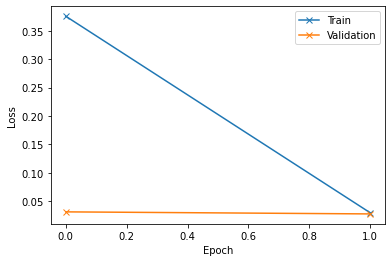

In [8]:
train_losses, valid_losses = losses
f, ax = plt.subplots()
ax.plot(train_losses, label="Train", color="C0", marker="x")
ax.plot(valid_losses, label="Validation", color="C1", marker="x")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.legend()

# Load the trained data

In [9]:
tester = Tester(cfg, ds)

Loading Data: 100%|██████████| 100/100 [00:00<00:00, 564.53it/s]


Test set Forward Pass: 100%|██████████| 194/194 [00:01<00:00, 128.18it/s]


<xarray.Dataset>
Dimensions:  (pixel: 100, time: 58)
Coordinates:
  * time     (time) datetime64[ns] 2016-03-30T23:58:53.302898688 ... 2020-12-...
    horizon  int64 1
  * pixel    (pixel) object '-11.760000000000005_-100.0' ... '75.024_60.0'
Data variables:
    sim      (time, pixel) float64 222.6 31.38 37.45 242.0 ... 290.4 106.3 214.7
    obs      (time, pixel) float64 217.9 28.4 40.18 250.2 ... 281.1 106.5 235.3

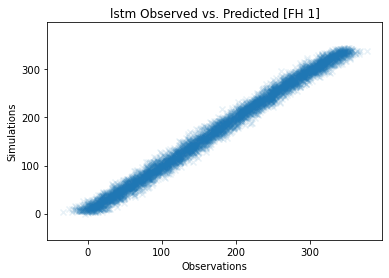

In [10]:
tester.run_test()

# The output forecasts! 

In [11]:
xr_path = sorted(list(cfg.run_dir.glob("*.nc")))[-1]
ds = xr.open_dataset(xr_path).drop("horizon")
ds

<xarray.Dataset>
Dimensions:  (pixel: 100, time: 58)
Coordinates:
  * time     (time) datetime64[ns] 2016-03-30T23:58:53.302898688 ... 2020-12-...
  * pixel    (pixel) object '-11.760000000000005_-100.0' ... '75.024_60.0'
Data variables:
    sim      (time, pixel) float64 ...
    obs      (time, pixel) float64 ...

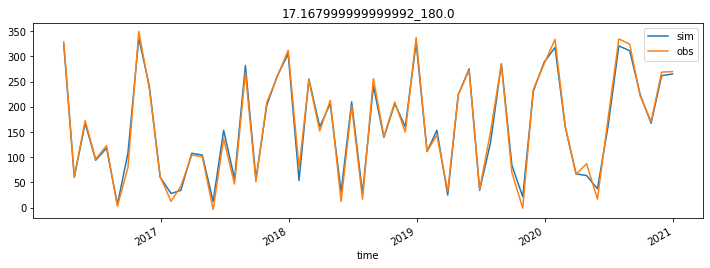

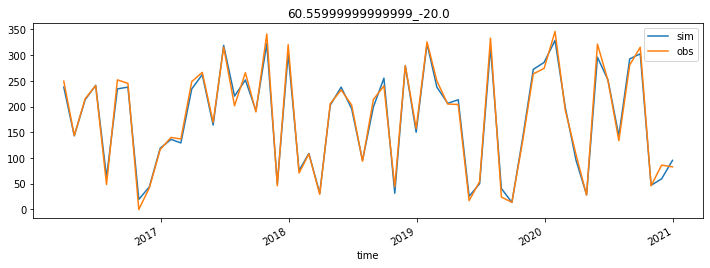

In [12]:
for i in np.arange(2):
    f, ax = plt.subplots(figsize=(12, 4))
    pixel = np.random.choice(ds.pixel.values)
    ds.sel(pixel=pixel).to_dataframe().plot(ax=ax)
    ax.set_title(pixel)